# Machine Learning Toolkit (Binary Classification)
## This program provides a tool used to do create a machine learning model on a given dataset.

## This works with binary classifcation, single label problems.

Take a dataset from Kaggle or from your own and upload it to this program: https://www.kaggle.com/datasets

In [1]:
import pandas as pd
import numpy as np
import sklearn as scikit_learn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import joblib as joblib
from joblib import dump, load
import tkinter as tk
from tkinter import *
np.random.seed(1000)
rstate = 12

In [2]:
root = Tk()
root.geometry("600x10000")
root.config(bg="lightgrey")
  
w = Label(root, text ='ML Options (Close when finished)', font = "30") 
w.pack()
  
Checkbutton1 = IntVar(value=1)  
Checkbutton2 = IntVar(value=1)  
Checkbutton3 = IntVar(value=1)
Checkbutton4 = IntVar(value=0)
Checkbutton5 = IntVar(value=0)
Checkbutton6 = IntVar(value=0)
Checkbutton7 = IntVar(value=0)
Checkbutton8 = IntVar(value=0)
Checkbutton9 = IntVar(value=0)
  
Button1 = Checkbutton(root, text = "oneHotEncode", 
                      variable = Checkbutton1,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
  
Button2 = Checkbutton(root, text = "Impute",
                      variable = Checkbutton2,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
  
Button3 = Checkbutton(root, text = "cutMissingRows",
                      variable = Checkbutton3,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)  
Button4 = Checkbutton(root, text = "removeOutliars",
                      variable = Checkbutton4,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)  

Button5 = Checkbutton(root, text = "Scaling",
                      variable = Checkbutton5,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)  

Button6 = Checkbutton(root, text = "QuantileTr.",
                      variable = Checkbutton6,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)  

Button7 = Checkbutton(root, text = "Normalize",
                      variable = Checkbutton7,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)  

Button7 = Checkbutton(root, text = "Normalize",
                      variable = Checkbutton7,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10) 

Button8 = Checkbutton(root, text = "Rebalance",
                      variable = Checkbutton8,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10) 

Button9 = Checkbutton(root, text = "FeatureSelection",
                      variable = Checkbutton9,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10) 
    

# File Name label and entry widgets
Label(root, text="File Name (Do not inlcude .csv or other tags)", bg="lightgrey").pack()
filename = Entry(root, bd=2)
filename.insert(0, "train")
filename.pack() 
#file_name = filename.get()

# File Type and dropdown widgets
file_type = StringVar(root)
file_type.set("Select a File Type")
filetype_menu = OptionMenu(root, file_type,'csv','excel')
filetype_menu.pack()
#filetype = file_type.get()
   
Button1.pack() # OneHotEncode
#OneHotEncode = Checkbutton1.get()
Button2.pack() # Impute 
#Impute = Checkbutton2.get()
Button3.pack() # cut Missing Rows
#cutMissingRows = Checkbutton3.get()
Button4.pack() # remove Outlairs
#removeOutlairs = Checkbutton4.get()

Label(root, text="(Only if you chose remove outliers)", bg="lightgrey").pack()
Label(root, text="Remove Outliars Threshold", bg="lightgrey").pack()
Threshold = Entry(root, bd=2)
Threshold.insert(0, "0")
Threshold.pack()
#threshold = Threshold.get()

Button5.pack() # Scaling
#Scaling = Checkbutton5.get()

# Scaling Type and dropdown widgets
Label(root, text="(Only if you chose Scaling)", bg="lightgrey").pack()
scale_type = StringVar(root)
scale_type.set("Select a Scaling Type")
scale_type_menu = OptionMenu(root, scale_type,'MinMaxScaler','RobustScaler','MaxAbsScaler','StandardScaler')
scale_type_menu.pack()
#scaletype = scale_type.get()

Button6.pack() # Quantile
#Quantile = Checkbutton6.get()
Button7.pack() # Normalize
#Normalize = Checkbutton7.get()
Button8.pack() # Rebalance
#Rebalance = Checkbutton8.get()

# Rebalance Type and dropdown widgets
Label(root, text="(Only if you chose Rebalance)", bg="lightgrey").pack()
reblance_type = StringVar(root)
reblance_type.set("Select a Rebalance Type")
reblance_type_menu = OptionMenu(root, reblance_type,'RandomUnderSampler','RandomOverSampler','SMOTE','ADASYN')
reblance_type_menu.pack()
#reblancetype = reblance_type.get()

Button9.pack() # FeatureSelection
#FeatureSelection = Checkbutton9.get()

# Feature Selection Type and dropdown widgets
Label(root, text="(Only if you chose FeatureSelection)", bg="lightgrey").pack()
featureselection_type = StringVar(root)
featureselection_type.set("Select a Feature Selection Type")
featureselection_type_menu = OptionMenu(root, featureselection_type,'MRMR','SelectKBest','SelectPercentile','VarianceThreshold')
featureselection_type_menu.pack()
#featureselectiontype = featureselection_type.get()

# Feature Selection Type 2 and dropdown widgets
Label(root, text="(Only if you chose SelectKBest or SelectPercentile)", bg="lightgrey").pack()
featureselection_type2 = StringVar(root)
featureselection_type2.set("Select a 2nd Feature Selection Type")
featureselection_type2_menu = OptionMenu(root, featureselection_type2,'f_classif','chi2')
featureselection_type2_menu.pack()
#featureselectiontype2 = featureselection_type2.get()

# N_features label and entry widgets
Label(root, text="# of features (Oly if you chose FeatureSelection)", bg="lightgrey").pack()
features = Entry(root, bd=2)
features.insert(0, "20")
features.pack() 
#n_features = features.get()

def getInput():
    
    global file_name
    file_name = filename.get()
    global filetype
    filetype = file_type.get()
    global OneHotEncode
    OneHotEncode = Checkbutton1.get()
    global Impute
    Impute = Checkbutton2.get()
    global cutMissingRows
    cutMissingRows = Checkbutton3.get()
    global removeOutlairs
    removeOutlairs = Checkbutton4.get()
    global threshold
    threshold = Threshold.get()
    global Scaling
    Scaling = Checkbutton5.get()
    global scaletype
    scaletype = scale_type.get()
    global Quantile
    Quantile = Checkbutton6.get()
    global Normalize
    Normalize = Checkbutton7.get()
    global Rebalance
    Rebalance = Checkbutton8.get()
    global reblancetype
    reblancetype = reblance_type.get()
    global FeatureSelection
    FeatureSelection = Checkbutton9.get()
    global featureselectiontype
    featureselectiontype = featureselection_type.get()
    global featureselectiontype2
    featureselectiontype2 = featureselection_type2.get()
    global n_features
    n_features = features.get()
    root.destroy()
    
#Sumbit values
Button(root, text = "submit",
           command = getInput).pack() 

mainloop() 

In [3]:
print(file_name)
print(filetype)
print(OneHotEncode)
print(Impute)
print(cutMissingRows)
print(removeOutlairs)
print(threshold)
print(Scaling)
print(scaletype)
print(Quantile)
print(Normalize)
print(Rebalance)
print(reblancetype)
print(FeatureSelection)
print(featureselectiontype)
print(featureselectiontype2)
print(n_features)

customer_data
csv
1
1
1
0
0
1
MinMaxScaler
0
0
1
SMOTE
0
Select a Feature Selection Type
Select a 2nd Feature Selection Type
20


In [4]:
root = Tk()
root.geometry("600x500")
root.config(bg="lightgrey")
  
x = Label(root, text ='ML Options 2 (Close when finished)', font = "30") 
x.pack()
 
Checkbutton10 = IntVar(value=0)
  
Button10 = Checkbutton(root, text = "SHAP", 
                      variable = Checkbutton10,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)

# Hyper. Tune Strategy and dropdown widgets
strategy_type = StringVar(root)
strategy_type.set("Select a Hyper. Tune Strategy")
strategy_type_menu = OptionMenu(root, strategy_type,'random','bayesian','grid')
strategy_type_menu.pack()
#strategytype = strategy_type.get()

# Hyper. Tune Num. Itr label and entry widgets
Label(root, text="Hyper. Tune # of Itr", bg="lightgrey").pack()
itr = Entry(root, bd=2)
itr.insert(0, "20")
itr.pack() 
#n_itr = itr.get()

# N_features label and entry widgets
Label(root, text="# of folds for Cross Vald.", bg="lightgrey").pack()
CV = Entry(root, bd=2)
CV.insert(0, "5")
CV.pack() 
#n_CV = CV.get()

# first feature label and entry widgets
Label(root, text="First feature name.", bg="lightgrey").pack()
firstFeature = Entry(root, bd=2)
firstFeature.pack() 

# last feature label and entry widgets
Label(root, text="Last feature name.", bg="lightgrey").pack()
lastFeature = Entry(root, bd=2)
lastFeature.pack() 

# Final Label label and entry widgets
Label(root, text="Label Name.", bg="lightgrey").pack()
final_label = Entry(root, bd=2)
final_label.pack() 

# Label Value 1 label and entry widgets
Label(root, text="(Only if label values are not 0/1).", bg="lightgrey").pack()
Label(root, text="Label Value 1.", bg="lightgrey").pack()
label_1 = Entry(root, bd=2)
label_1.insert(0, "label_1")
label_1.pack() 

# Label Value 2 label and entry widgets
Label(root, text="Label Value 2.", bg="lightgrey").pack()
label_2 = Entry(root, bd=2)
label_2.insert(0, "label_2")
label_2.pack() 

Button10.pack() # SHAP
#SHAP = Checkbutton10.get()

def getInput():
    
    global strategytype
    strategytype = strategy_type.get()
    global n_itr
    n_itr = itr.get()
    global n_CV
    n_CV = CV.get()
    global SHAP
    SHAP = Checkbutton10.get()
    global first_Feature
    first_Feature = firstFeature.get()
    global last_Feature
    last_Feature = lastFeature.get()
    global output_label
    output_label = final_label.get()
    global first_label
    first_label = label_1.get()
    global second_label
    second_label = label_2.get()
    
    root.destroy()
    
#Sumbit values
Button(root, text = "submit",
           command = getInput).pack() 
  
mainloop() 

In [5]:
print(strategytype)
print(n_itr)
print(n_CV)
print(SHAP)
print(first_Feature)
print(last_Feature)
print(output_label)
print(first_label)
print(second_label)

random
20
5
0
fea_1
fea_11
label
label_1
label_2


In [6]:
root = Tk()
root.geometry("600x500")
root.config(bg="lightgrey")
  
y = Label(root, text ='ML Algorithims to Use (Must have at least 1)', font = "30") 
y.pack()
 
Checkbutton11 = IntVar(value=1)
Checkbutton12 = IntVar(value=0)
Checkbutton13 = IntVar(value=0)
Checkbutton14 = IntVar(value=0)
Checkbutton15 = IntVar(value=0)
Checkbutton16 = IntVar(value=0)
Checkbutton17 = IntVar(value=0)
Checkbutton18 = IntVar(value=0)

Checkbutton20 = IntVar(value=0)
Checkbutton21 = IntVar(value=0)
  
Button11 = Checkbutton(root, text = "Random Forest", 
                      variable = Checkbutton11,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button12 = Checkbutton(root, text = "XGBoost", 
                      variable = Checkbutton12,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button13 = Checkbutton(root, text = "Cat Boost", 
                      variable = Checkbutton13,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button14 = Checkbutton(root, text = "SGD Elastic", 
                      variable = Checkbutton14,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button15 = Checkbutton(root, text = "SGD L2", 
                      variable = Checkbutton15,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button16 = Checkbutton(root, text = "Logistic Reg. L2", 
                      variable = Checkbutton16,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button17 = Checkbutton(root, text = "Logistic Reg.", 
                      variable = Checkbutton17,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button18 = Checkbutton(root, text = "Descision Tree", 
                      variable = Checkbutton18,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button20 = Checkbutton(root, text = "SVM", 
                      variable = Checkbutton20,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)
Button21 = Checkbutton(root, text = "KNearest N.", 
                      variable = Checkbutton21,
                      onvalue = 1,
                      offvalue = 0,
                      height = 2,
                      width = 10)


Button11.pack() # rf
Button12.pack() # xgb
Button13.pack() # cat
Button14.pack() # sgd_elastic
Button15.pack() # sgd_l2
Button16.pack() # lr_l2
Button17.pack() # lr
Button18.pack() # dt
Button20.pack() # svm
Button21.pack() # knn


def getInput():
    
    global algorithms
    algorithms = []
    
    rf = Checkbutton11.get()
    if rf == 1:
        algorithms.append("rf")
    xgb = Checkbutton12.get()
    if xgb == 1:
        algorithms.append("xgb")
    cat = Checkbutton13.get()
    if cat == 1:
        algorithms.append("cat")
    sgd_elastic = Checkbutton14.get()
    if sgd_elastic == 1:
        algorithms.append("sgd_elastic")
    sgd_l2 = Checkbutton15.get()
    if sgd_l2 == 1:
        algorithms.append("sgd_l2")
    lr_l2 = Checkbutton16.get()
    if lr_l2 == 1:
        algorithms.append("lr_l2")
    lr = Checkbutton17.get()
    if lr == 1:
        algorithms.append("lr")
    dt = Checkbutton18.get()
    if dt == 1:
        algorithms.append("dt")
    svm = Checkbutton20.get()
    if svm == 1:
        algorithms.append("svm")
    knn = Checkbutton21.get()
    if knn == 1:
        algorithms.append("knn")
    
    root.destroy()
    
#Sumbit values
Button(root, text = "submit",
           command = getInput).pack() 
  
mainloop() 

In [7]:
print(algorithms)

options = {
    'oneHotEncode' : True if OneHotEncode == 1 else False, 
    'Impute': True if Impute == 1 else False, 
    'cutMissingRows' : True if cutMissingRows == 1 else False,
    'removeBig': True if removeOutlairs == 1 else False, 
    'removeBig_N': int(threshold), 
    'Scaling': True if Scaling == 1 else False, 
    'scalingMethod': scaletype, 
    'QuantileTransformer':True if Quantile == 1 else False, 
    'Normalize':True if Normalize == 1 else False,
    'rebalance' : True if Rebalance == 1 else False,
    'rebalance_type':reblancetype,
    'FeatureSelection': True if FeatureSelection == 1 else False,
    'method': featureselectiontype, 
    "type": featureselectiontype2, 
    'N_features': int(n_features), 
    'per':10,
    'strategy': strategytype, 
    'itr': int(n_itr),
    'CV': int(n_CV),
    'SHAP': True if SHAP == 1 else False
}

with open("parameter_setup.txt", 'w') as f: 
    f.write('Data Set Name: %s\n' % file_name)
    f.write('ML Alogorithims: %s\n' % algorithms)
    for key, value in options.items(): 
        f.write('%s:%s\n' % (key, value))
f.close()

['rf', 'xgb', 'sgd_elastic', 'sgd_l2', 'lr_l2', 'lr', 'dt', 'svm', 'knn']


In [8]:
pip install mrmr_selection

Note: you may need to restart the kernel to use updated packages.


In [9]:
import mrmr
from mrmr import mrmr_classif

In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [12]:
import xgboost
import catboost

In [13]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [14]:
from skopt import BayesSearchCV

In [15]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [16]:
import shap

In [17]:
# filename = #--->  Insert file name here  <----#

filename = file_name

if filetype == 'csv':
    #filename = filename + ".csv"
    raw_df = pd.read_csv(filename + ".csv" )
elif filetype == 'excel':
    #filename = filename + ".xlsx"
    raw_df = pd.read_excel(filename + ".xlsx")
else:
    #filename = filename + ".csv"
    raw_df = pd.read_csv(filename + ".csv" )

In [18]:
df = raw_df.copy()

In [19]:
df.head(10)

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
5,0,59005995,6,1217.0,3,56000.0,2,6,-1,100,3,60091,1.000000
6,1,59001917,4,1304.0,3,35000.0,2,8,9,85,5,60069,1.000000
7,1,54984789,5,1256.0,3,78000.0,2,15,-1,111,3,60030,1.000000
8,0,58984557,5,1323.5,3,218000.0,2,15,5,112,4,151300,282.842713
9,0,54990497,4,NaN,2,35000.0,2,8,5,101,3,60029,237.301496


In [20]:
# By default, we should cut rows that have missing series of values (cutMissing), impute the data (Impute), and remove very large data values (removeBig)
def preprocess(df, input_cols, label_cols, numeric_cols, categorical_cols, Impute=True, cutMissingRows=True, oneHotEncode=True, removeBig=False, N=20000, Scaling=False, scalingMethod='MinMaxScaler', QuantileTransformer=False, Normalize=False):
    if oneHotEncode == True:
        print("oneHotEncode")
        # One Hot Encode catagorical variables
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoder.fit(raw_df[categorical_cols])
        encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
        df[encoded_cols] = encoder.transform(df[categorical_cols])
        input_cols = numeric_cols + encoded_cols
    
    if Impute == True:
        print("Impute")
        # Impute the remaining missing numeric data
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(df[numeric_cols])
        df[numeric_cols] = imputer.transform(df[numeric_cols])
        
    if cutMissingRows == True:
        print("cutMissingRows")
        # Drop rows with missing values
        df = df.dropna()
    
    if removeBig == True:
        print("removeBig")
        # Remove rows that have a value greater than N for any column. Default N is 20000
        for column  in df[numeric_cols]:
            df = df.drop(df.index[df[column] > N])
    
    if Scaling == True:
        print("Scaling")
        # Scaling the input features for a chosen method. Default is MinMaxScaler.
        if scalingMethod == 'MinMaxScaler': 
            print("MinMaxScaler")
            # This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
        elif scalingMethod == 'RobustScaler':
            print("RobustScaler")
            # This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
        elif scalingMethod == 'MaxAbsScaler':
            print("MaxAbsScaler")
            # Scale each feature by its maximum absolute value.
            from sklearn.preprocessing import MaxAbsScaler
            scaler = MaxAbsScaler()
        elif scalingMethod == 'StandardScaler':
            print("StandardScaler")
            # Standardize features by removing the mean and scaling to unit variance.
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
        scaler.fit(df[numeric_cols])
        df[numeric_cols] = scaler.transform(df[numeric_cols])
        
    if QuantileTransformer == True:  
        print("QuantileTransformer")
        # transforms the features to follow a uniform or a normal distribution.
        from sklearn.preprocessing import QuantileTransformer
        qt = QuantileTransformer(output_distribution='normal').fit(df[numeric_cols])
        df[numeric_cols] = qt.transform(df[numeric_cols])
        
    if Normalize == True:  
        print("Normalize")
        # Normalize the data
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer().fit(df[numeric_cols])
        df[numeric_cols] = normalizer.transform(df[numeric_cols])
        
    
    return df, input_cols

In [21]:
# Split data into input and output sets
def split(df, input_cols, label_cols):
    input_df = df[input_cols].copy()
    output_df = df[label_cols].copy()
    
    return input_df, output_df

In [22]:
#rebalance the imbalanced data with a chosen label
def rebalance(input_df, label_df, type='RandomUnderSampler'):
    if type == 'RandomUnderSampler':
        # random undersampling reduces the number of majority class randomly down to the desired ratio against the minority class.
        from imblearn.under_sampling import RandomUnderSampler
        rebalance = RandomUnderSampler()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)
    elif type == 'RandomOverSampler':
        # Naive random over-sampling.
        from imblearn.over_sampling import RandomOverSampler
        rebalance = RandomOverSampler()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)
    elif type == 'SMOTE':
        # SMOTE is a technique to up-sample the minority classes while avoiding overfitting.
        from imblearn.over_sampling import SMOTE
        rebalance = SMOTE()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)    
    elif type == 'ADASYN':
        # Adaptive Synthetic (ADASYN) algorithm. This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.
        from imblearn.over_sampling import ADASYN
        rebalance = ADASYN()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)                   
    else:
        print("Cannot do")
        input_df2, label_df2 = input_df, label_df
        
    return input_df2, label_df2  

In [23]:
def feature_selection(input_df, output_df, method="MRMR", type='f_classif', N=20, per=10):
    if method=="MRMR":
        selected_features = mrmr_classif(X=input_df, y=output_df, K=N)
        input_df_new = input_df[selected_features]
    elif method=="SelectKBest":
        if type=='f_classif':
            best_features =  SelectKBest(f_classif, k=N)
            best_features.fit(input_df, output_df)
        elif type=='chi2':
            best_features =  SelectKBest(chi2, k=N)
            best_features.fit(input_df, output_df)
        # Get columns to keep and create new dataframe with those only
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    elif method=="SelectPercentile": # Select features according to a percentile of the highest scores.
        if type=='f_classif':
            best_features =  SelectPercentile(f_classif, percentile=per)
            best_features.fit(input_df, output_df)
        elif type=='chi2':
            best_features =  SelectPercentile(chi2, percentile=per)
            best_features.fit(input_df, output_df)
        # Get columns to keep and create new dataframe with those only
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    elif method=="VarianceThreshold": # Feature selector that removes all low-variance features.
        best_features = VarianceThreshold()
        best_features.fit(input_df)
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    
    return input_df_new, list(input_df_new.columns)

In [24]:
# define a model to use and its set of parameters
def get_classifier(alg):
    est_rs = 1000
    if alg == 'rf':
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier(random_state=est_rs)
        param_vals = {'max_depth': [10, 20, 30, 50, 100, 150, 200], 'n_estimators': [20, 30, 50, 70, 100, 120],
                      'max_samples': [0.75, 0.80, 0.85, 0.90, 0.95]}
    elif alg == 'dt':
        from sklearn.tree import DecisionTreeClassifier
        estimator = DecisionTreeClassifier()
        param_vals = {'max_depth': [2, 3, 4, 5, 8], 'min_samples_split': [2, 3, 4, 5, 7, 10], 
                      'random_state': [0, 1, 5, 10,50,100]}
    elif alg == 'xgb':
        from xgboost import XGBClassifier
        estimator = XGBClassifier(objective='binary:logistic', booster='gbtree', nthread=4, eval_metric='auc',
                                  use_label_encoder=False, random_state=est_rs)
        param_vals = {'max_depth': [2, 3, 4, 6, 8], 'n_estimators': [80, 90, 100, 110, 120, 200], 
                      'learning_rate': [0.00001, 0.0001, 0.001, 0.01], 'colsample_bytree': [0.85, 0.90, 0.95, 1.0]}
    elif alg == 'cat':
        from catboost import CatBoostClassifier
        cat_features = []
        estimator = CatBoostClassifier(loss_function='Logloss', nan_mode='Min', cat_features=cat_features,
                                       one_hot_max_size=31, random_state=est_rs)
        param_vals = {'max_depth': [4, 8, 12, 16, 20], 'n_estimators': [20, 30, 50, 70, 100, 120], 
                      'learning_rate': [0.0001, 0.001, 0.01, 0.1]}
    elif alg == 'sgd_elastic':
        from sklearn.linear_model import SGDClassifier # stochastic gradient descent (SGD)
        estimator = SGDClassifier(loss='log', penalty='elasticnet')
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'sgd_l2':
        from sklearn.linear_model import SGDClassifier
        estimator = SGDClassifier(loss='log', penalty='l2')
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'lr_l2': # Logistic Regression
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression(penalty='l2')
        param_vals = {'random_state': [0, 1, 5, 10,50,100], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'lr':
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression()
        param_vals = {'random_state': [0, 1, 5, 10,50,100], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}        
    elif alg == 'svm':
        from sklearn import svm
        estimator = svm.SVC(probability=True)
        param_vals = {'C': [0.5, 1, 1.5, 2, 2.5, 3], 'degree': [2, 3, 4, 5]}            
    elif alg == 'knn': # k-nearest neighbors
        from sklearn.neighbors import KNeighborsClassifier
        estimator = KNeighborsClassifier()
        param_vals = {'n_neighbors': [5, 10, 15, 20, 25, 30], 'leaf_size': [20, 30, 40, 50]}  
        
    return estimator, param_vals

In [25]:
def train_tune(estimator, param_vals, X_train, y_train, strategy='random', itr=20):
    if strategy == 'random':
        random_df = RandomizedSearchCV(estimator, param_distributions=param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        random_df.fit(X_train, y_train)
        best_model = random_df.best_estimator_

    elif strategy == 'bayesian':
        bayes_df = BayesSearchCV(estimator, param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        bayes_df.fit(X_train, y_train)
        best_model = bayes_df.best_estimator_
    elif strategy == 'grid':
        grid_df = GridSearchCV(estimator, param_vals, n_jobs=-1, return_train_score=True)
        grid_df.fit(X_train, y_train)
        best_model = grid_df.best_estimator_ 
    else:
        random_df = RandomizedSearchCV(estimator, param_distributions=param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        random_df.fit(X_train, y_train)
        best_model = random_df.best_estimator_
        
    return best_model

In [26]:
def train_tune(estimator, param_vals, X_train, y_train, strategy='random', itr=20):
    if strategy == 'random':
        random_df = RandomizedSearchCV(estimator, param_distributions=param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        random_df.fit(X_train, y_train)
        best_model = random_df.best_estimator_

    elif strategy == 'bayesian':
        bayes_df = BayesSearchCV(estimator, param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        bayes_df.fit(X_train, y_train)
        best_model = bayes_df.best_estimator_
    elif strategy == 'grid':
        grid_df = GridSearchCV(estimator, param_vals, n_jobs=-1, return_train_score=True)
        grid_df.fit(X_train, y_train)
        best_model = grid_df.best_estimator_   
        
    return best_model

In [27]:
_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

def perf_measure(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # true positive rate
    tnr = TN/(TN + FP) # true negative rate

    return "TP:" + str(TP) + " FP:" + str(FP) + " TN:" + str(TN) + " FN:" + str(FN), "TP Rate:" + str(tpr) + " TN Rate:" + str(tnr)

In [28]:
def plot_sklearn_roc_curve(test_real, test_pred, train_real, train_pred, algo, label):  
    plt.figure(0).clf()

    fpr, tpr, _ = roc_curve(train_real, train_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label="Training Set, auc="+str(roc_auc))

    fpr, tpr, _ = roc_curve(test_real, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label="Test Set, auc="+str(roc_auc))
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.legend(loc=0)
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Postive Rate")
    
    filename = algo + '_' + label + ".png"
    plt.savefig(filename)
    plt.show()

In [29]:
# Get the feature variables and labels
#input_cols = df.loc[:, "---> INPUT COLUMNS NAMES or RANGE <----"].columns.tolist()
#label_cols = df.loc[:, "---> LABEL COLUMNS NAME or RANGE <----"].columns.tolist()

input_cols = df.loc[:, first_Feature: last_Feature].columns.tolist()
label_cols = output_label


input_df = df.loc[:, input_cols]

numeric_cols = input_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = input_df.select_dtypes('object').columns.tolist()

In [30]:
input_df.head(10)

,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
5,6,1217.0,3,56000.0,2,6,-1,100,3,60091,1.000000
6,4,1304.0,3,35000.0,2,8,9,85,5,60069,1.000000
7,5,1256.0,3,78000.0,2,15,-1,111,3,60030,1.000000
8,5,1323.5,3,218000.0,2,15,5,112,4,151300,282.842713
9,4,NaN,2,35000.0,2,8,5,101,3,60029,237.301496


In [31]:
numeric_cols

['fea_1',
 'fea_2',
 'fea_3',
 'fea_4',
 'fea_5',
 'fea_6',
 'fea_7',
 'fea_8',
 'fea_9',
 'fea_10',
 'fea_11']

In [32]:
categorical_cols

[]

In [33]:
def data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options):
    #Preprocess data
    df_new, input_cols = preprocess(df, input_cols, label_cols, numeric_cols, categorical_cols, oneHotEncode=options['oneHotEncode'], 
                    Impute=options['Impute'], cutMissingRows=options['cutMissingRows'],
                    removeBig=options['removeBig'], N=options['removeBig_N'],
                   Scaling=options['Scaling'], scalingMethod=options['scalingMethod'], 
                        QuantileTransformer=options['QuantileTransformer'],
                        Normalize=options['Normalize'])

    #Split data into train/val/test sets
    train_val_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)
    
    #Seperate the inputs and outputs for training data
    input_df_train, output_df_train = split(train_val_df, input_cols, label_cols)
    
    #Seperate the inputs and outputs for test data
    input_df_test, output_df_test = split(test_df, input_cols, label_cols)
    
    return input_df_train, output_df_train, input_df_test, output_df_test
    #return train_val_df, test_df
    
input_df_train, output_df_train, input_df_test, output_df_test  = data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options)  
#train_val_df, test_df = data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options) 

oneHotEncode
Impute
cutMissingRows
Scaling
MinMaxScaler


In [34]:
input_df_train.head(10)

,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
570,0.500000,0.337449,1.0,0.074262,1.0,0.384615,0.545455,0.764706,1.00,0.000061,0.345485
875,1.000000,0.584362,1.0,0.083544,1.0,0.615385,0.545455,0.235294,1.00,0.000068,0.281827
712,0.500000,0.481481,0.0,0.084388,1.0,0.384615,0.545455,0.980392,1.00,0.491569,0.270998
554,0.666667,0.913580,1.0,0.063291,1.0,0.923077,0.545455,0.843137,0.75,0.000154,0.222507
688,0.666667,0.292181,1.0,0.032911,1.0,0.923077,0.000000,0.941176,0.75,0.660969,0.238924
780,0.500000,0.485597,1.0,0.156962,1.0,0.384615,0.909091,0.960784,1.00,0.020420,0.315259
184,1.000000,0.459290,0.5,0.032068,1.0,0.615385,0.545455,0.803922,0.75,0.154739,0.262316
504,0.666667,0.205761,1.0,0.032068,1.0,0.923077,0.545455,0.980392,0.75,0.020337,0.263534
969,0.500000,0.592593,0.0,0.076793,1.0,0.384615,0.545455,0.705882,0.50,0.000056,0.000000
568,0.666667,0.312757,1.0,0.038819,1.0,0.923077,0.545455,0.882353,0.75,0.000034,0.243880


In [35]:
output_df_train.head(10)

570    0
875    0
712    1
554    0
688    0
780    0
184    0
504    0
969    1
568    0
Name: label, dtype: int64

In [36]:
if first_label in output_df_train.tolist() and second_label in output_df_train.tolist():
    output_df_train = output_df_train.map({first_label: 1, second_label: 0})
output_df_train.head(10)

570    0
875    0
712    1
554    0
688    0
780    0
184    0
504    0
969    1
568    0
Name: label, dtype: int64

In [37]:
output_df_test.head(10)

1089    0
1103    1
739     0
140     0
1018    0
527     0
812     0
481     0
1118    0
950     1
Name: label, dtype: int64

In [38]:
if first_label in output_df_test.tolist() and second_label in output_df_test.tolist():
    output_df_test = output_df_test.map({first_label: 1, second_label: 0})
output_df_test.head(10)

1089    0
1103    1
739     0
140     0
1018    0
527     0
812     0
481     0
1118    0
950     1
Name: label, dtype: int64

In [39]:
def cross_validation(input_df_train, output_df_train, input_df_test, output_df_test, options, algorithms, _scoring):
    for algorithm in algorithms:
        filename = algorithm + ".txt"
        f = open(filename, "w")
        print("_____________________________________________________________________________________________________")
        print("Algorithm:", algorithm)
        print("Label:", output_df_train.name)
        f.write("_____________________________________________________________________________________________________")
        f.write("\nAlgorithm: %s"% algorithm)
        f.write("\nLabel: %s"% output_df_train.name)
        if options['rebalance'] == True:
            input_df_train_reb, output_df_train_reb = rebalance(input_df_train, output_df_train, options['rebalance_type'])
        else:
            input_df_train_reb = input_df_train.copy()
            output_df_train_reb = output_df_train.copy()
        if options['FeatureSelection'] == True:
            input_df_train_fs, selected_features = feature_selection(input_df_train_reb, output_df_train_reb, method=options['method'], type=options['type'], N=options['N_features'], per=options['per'])
            print(selected_features)
            f.write("\nSelected Features: %s"%selected_features)
        else:
            input_df_train_fs = input_df_train_reb.copy()
            selected_features = list(input_df_train_reb.columns)
        estimator, param_vals = get_classifier(algorithm)
        #if algorithm in ['rf', 'xgb', 'cat']:
            #estimator = CalibratedClassifierCV(estimator, method='sigmoid', cv=5)
        best_model = train_tune(estimator, param_vals, input_df_train_fs, output_df_train_reb, options['strategy'], itr=options['itr'])
        params = best_model.get_params()
        f.write("\nParameters: %s"%params)
        results = cross_validate(estimator=best_model,
                                   X=input_df_train_fs,
                                   y=output_df_train_reb,
                                   cv=options['CV'],
                                   scoring=_scoring,
                                   return_train_score=True, return_estimator=True)
        model_fit = results['estimator'][0]
        print(model_fit)
        #f.write("Training Accuracy scores %s"% results['train_accuracy'])
        f.write("\nMean Training Accuracy %s"% (results['train_accuracy'].mean()*100))
        #f.write("\nTraining Precision scores %s"% results['train_precision'])
        f.write("\nMean Training Precision %s"% results['train_precision'].mean())
        #f.write("\nTraining Recall scores %s"% results['train_recall'])
        f.write("\nMean Training Recall %s"% results['train_recall'].mean())
        #f.write("\nTraining F1 scores %s"% results['train_f1'])
        f.write("\nMean Training F1 Score %s"% results['train_f1'].mean())
        #f.write("\nTraining AUC scores %s"% results['train_roc_auc'])
        f.write("\nMean Training AUC Score %s"% results['train_roc_auc'].mean())
        #f.write("\nValidation Accuracy scores %s"% results['test_accuracy'])
        f.write("\nMean Validation Accuracy %s"% (results['test_accuracy'].mean()*100))
        #f.write("\nValidation Precision scores %s"% results['test_precision'])
        f.write("\nMean Validation Precision %s"% results['test_precision'].mean())
        #f.write("\nValidation Recall scores %s"% results['test_recall'])
        f.write("\nMean Validation Recall %s"% results['test_recall'].mean())
        #f.write("\nValidation F1 scores %s"% results['test_f1'])
        f.write("\nMean Validation F1 Score %s"% results['test_f1'].mean())
        #f.write("\nValidation AUC scores %s"% results['test_roc_auc'])
        f.write("\nMean Validation AUC Score %s"% results['test_roc_auc'].mean())
        probas_train = model_fit.predict_proba(input_df_train[selected_features])
        predictions_test = model_fit.predict(input_df_test[selected_features])
        probas_test = model_fit.predict_proba(input_df_test[selected_features])
        print(probas_test)
        acc_score = accuracy_score(output_df_test, predictions_test)
        f.write("\n Test Acuracy Score: %s"%acc_score)
        print("Test Acuracy Score:", acc_score)
        filename_prob = algorithm + "_" + output_df_test.name + "_prob.joblib"
        filename_pred = algorithm + "_" + output_df_test.name + "_pred.joblib"
        joblib.dump(probas_test, filename_prob)
        joblib.dump(predictions_test, filename_pred)
        modelname = algorithm + "_" + output_df_test.name + "_model.joblib"
        joblib.dump(model_fit, modelname)
        #"""
        if options['SHAP'] == True:
            explainer = shap.Explainer(model_fit.predict, input_df_train_fs[selected_features])
            shap_value = explainer(input_df_train_fs[selected_features])
            #shap.plots.beeswarm(shap_value, show=True)
            shap.summary_plot(shap_value, input_df_train_fs[selected_features], max_display=10, show=False)
            filename_shap = algorithm + "_" + output_df_train.name + "_shap.png"
            plt.savefig(filename_shap,dpi=700)
        #"""
        f.write('\n')
        # Plots the ROC curve using the sklearn methods
        plot_sklearn_roc_curve(output_df_test, probas_test[:, 1], output_df_train, probas_train[:, 1], algorithm, output_df_test.name)
    f.close()

_____________________________________________________________________________________________________
Algorithm: rf
Label: label
RandomForestClassifier(max_depth=100, max_samples=0.9, n_estimators=50,
                       random_state=1000)
[[0.66 0.34]
 [0.32 0.68]
 [0.84 0.16]
 [0.84 0.16]
 [0.6  0.4 ]
 [0.6  0.4 ]
 [0.62 0.38]
 [1.   0.  ]
 [0.44 0.56]
 [0.46 0.54]
 [0.84 0.16]
 [0.48 0.52]
 [0.46 0.54]
 [0.64 0.36]
 [0.62 0.38]
 [0.84 0.16]
 [1.   0.  ]
 [0.78 0.22]
 [0.96 0.04]
 [0.68 0.32]
 [0.84 0.16]
 [0.78 0.22]
 [0.78 0.22]
 [0.76 0.24]
 [0.8  0.2 ]
 [0.96 0.04]
 [0.84 0.16]
 [0.9  0.1 ]
 [0.8  0.2 ]
 [0.48 0.52]
 [0.72 0.28]
 [0.52 0.48]
 [0.48 0.52]
 [0.5  0.5 ]
 [0.68 0.32]
 [0.56 0.44]
 [0.68 0.32]
 [0.98 0.02]
 [0.7  0.3 ]
 [0.6  0.4 ]
 [0.54 0.46]
 [0.56 0.44]
 [0.88 0.12]
 [0.7  0.3 ]
 [0.48 0.52]
 [0.74 0.26]
 [0.54 0.46]
 [0.86 0.14]
 [0.8  0.2 ]
 [0.98 0.02]
 [0.5  0.5 ]
 [0.76 0.24]
 [0.44 0.56]
 [0.28 0.72]
 [0.7  0.3 ]
 [0.78 0.22]
 [0.8  0.2 ]
 [0.58 0.42]
 [0

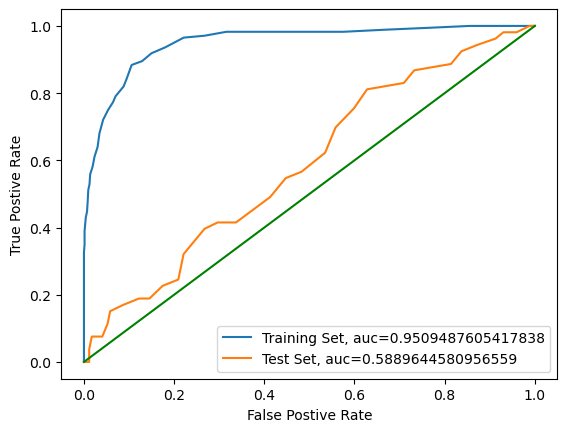

_____________________________________________________________________________________________________
Algorithm: xgb
Label: label
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)
[[0.61006665 0.38993335]
 [0.47950017 0.5204998 ]
 [0.6918186  0.30818138]
 [0.69184667 0.30815333]
 [0.6420947  0.35790533]


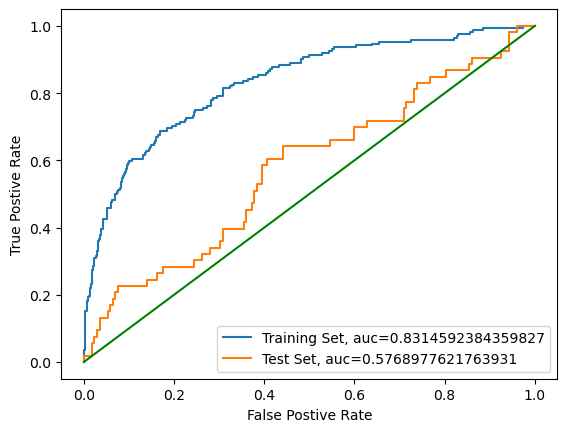

_____________________________________________________________________________________________________
Algorithm: sgd_elastic
Label: label
SGDClassifier(alpha=0.001, l1_ratio=1, loss='log', penalty='elasticnet')
[[0.62342019 0.37657981]
 [0.44180481 0.55819519]
 [0.65000815 0.34999185]
 [0.5290322  0.4709678 ]
 [0.41163506 0.58836494]
 [0.54411963 0.45588037]
 [0.5463368  0.4536632 ]
 [0.61545271 0.38454729]
 [0.36501673 0.63498327]
 [0.50779083 0.49220917]
 [0.59925276 0.40074724]
 [0.4445865  0.5554135 ]
 [0.3728523  0.6271477 ]
 [0.45405757 0.54594243]
 [0.46114428 0.53885572]
 [0.50603223 0.49396777]
 [0.57954955 0.42045045]
 [0.65247017 0.34752983]
 [0.58862043 0.41137957]
 [0.48764013 0.51235987]
 [0.6220194  0.3779806 ]
 [0.61479051 0.38520949]
 [0.66745995 0.33254005]
 [0.59931092 0.40068908]
 [0.56880709 0.43119291]
 [0.70664069 0.29335931]
 [0.62001825 0.37998175]
 [0.56013351 0.43986649]
 [0.61733848 0.38266152]
 [0.42567345 0.57432655]
 [0.55591509 0.44408491]
 [0.36979327 0

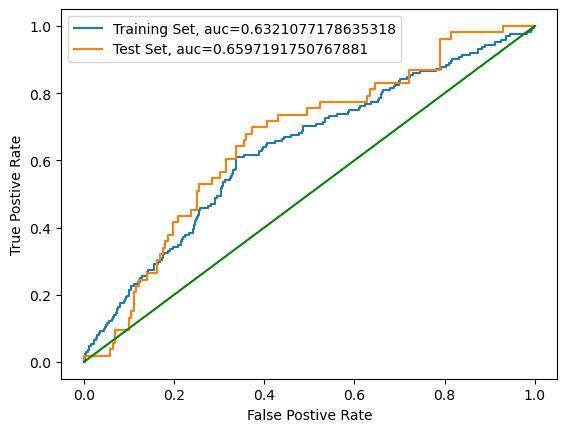

_____________________________________________________________________________________________________
Algorithm: sgd_l2
Label: label
SGDClassifier(l1_ratio=0.25, loss='log')
[[7.79375678e-01 2.20624322e-01]
 [5.54780253e-01 4.45219747e-01]
 [7.85729950e-01 2.14270050e-01]
 [5.88551144e-01 4.11448856e-01]
 [5.16517022e-01 4.83482978e-01]
 [6.85765135e-01 3.14234865e-01]
 [7.04681628e-01 2.95318372e-01]
 [7.53930203e-01 2.46069797e-01]
 [4.06517890e-01 5.93482110e-01]
 [5.57540589e-01 4.42459411e-01]
 [6.80885241e-01 3.19114759e-01]
 [4.63428050e-01 5.36571950e-01]
 [4.24643635e-01 5.75356365e-01]
 [5.94024005e-01 4.05975995e-01]
 [5.88857983e-01 4.11142017e-01]
 [6.12987794e-01 3.87012206e-01]
 [6.85171395e-01 3.14828605e-01]
 [7.64653896e-01 2.35346104e-01]
 [7.19932596e-01 2.80067404e-01]
 [6.21898622e-01 3.78101378e-01]
 [7.01965125e-01 2.98034875e-01]
 [6.99546390e-01 3.00453610e-01]
 [7.77658385e-01 2.22341615e-01]
 [7.57052936e-01 2.42947064e-01]
 [6.98059511e-01 3.01940489e-01]
 

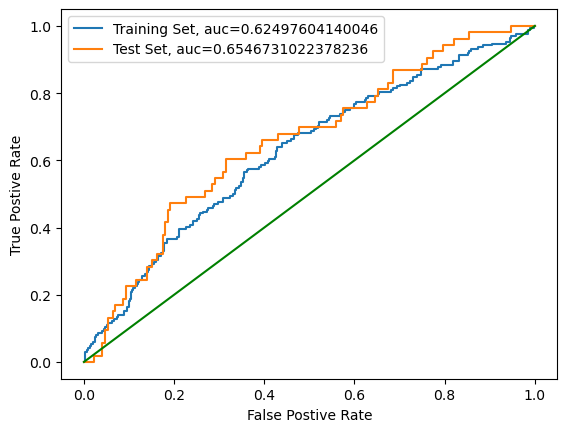

_____________________________________________________________________________________________________
Algorithm: lr_l2
Label: label
LogisticRegression(l1_ratio=0.15, random_state=0)
[[0.59233088 0.40766912]
 [0.43456488 0.56543512]
 [0.57801416 0.42198584]
 [0.49723985 0.50276015]
 [0.39058153 0.60941847]
 [0.4996993  0.5003007 ]
 [0.54849507 0.45150493]
 [0.57477828 0.42522172]
 [0.31830687 0.68169313]
 [0.50269389 0.49730611]
 [0.57202462 0.42797538]
 [0.42089312 0.57910688]
 [0.38840877 0.61159123]
 [0.4358897  0.5641103 ]
 [0.4681277  0.5318723 ]
 [0.50666519 0.49333481]
 [0.57414855 0.42585145]
 [0.54154098 0.45845902]
 [0.54733323 0.45266677]
 [0.49083074 0.50916926]
 [0.56230754 0.43769246]
 [0.55070928 0.44929072]
 [0.6409578  0.3590422 ]
 [0.60101966 0.39898034]
 [0.55604326 0.44395674]
 [0.63256667 0.36743333]
 [0.54039147 0.45960853]
 [0.57881704 0.42118296]
 [0.51643952 0.48356048]
 [0.41477528 0.58522472]
 [0.50131595 0.49868405]
 [0.36737067 0.63262933]
 [0.40882714 0.591

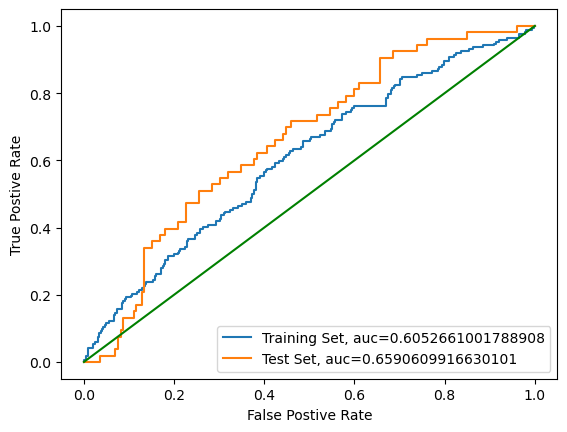

_____________________________________________________________________________________________________
Algorithm: lr
Label: label
LogisticRegression(l1_ratio=0.15, random_state=0)
[[0.61153161 0.38846839]
 [0.46411846 0.53588154]
 [0.58723776 0.41276224]
 [0.46777818 0.53222182]
 [0.40250825 0.59749175]
 [0.49667206 0.50332794]
 [0.56434891 0.43565109]
 [0.58488754 0.41511246]
 [0.32389318 0.67610682]
 [0.49314635 0.50685365]
 [0.54240628 0.45759372]
 [0.42584457 0.57415543]
 [0.39684543 0.60315457]
 [0.45108127 0.54891873]
 [0.461835   0.538165  ]
 [0.48134222 0.51865778]
 [0.52301689 0.47698311]
 [0.57134964 0.42865036]
 [0.5489482  0.4510518 ]
 [0.48755009 0.51244991]
 [0.56835817 0.43164183]
 [0.57474727 0.42525273]
 [0.68681562 0.31318438]
 [0.60913848 0.39086152]
 [0.5666146  0.4333854 ]
 [0.61345923 0.38654077]
 [0.57498588 0.42501412]
 [0.59880416 0.40119584]
 [0.49803159 0.50196841]
 [0.3969497  0.6030503 ]
 [0.48764469 0.51235531]
 [0.35415954 0.64584046]
 [0.36743529 0.632564

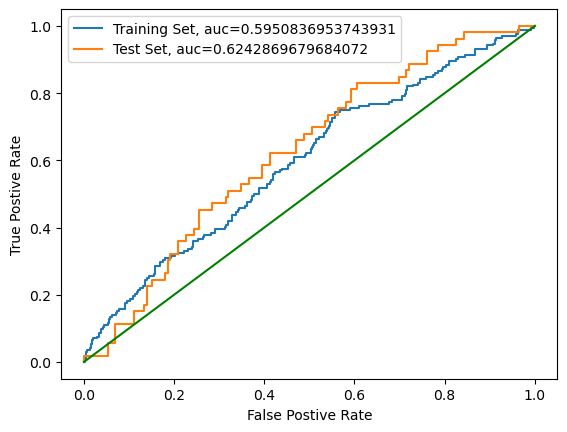

_____________________________________________________________________________________________________
Algorithm: dt
Label: label
DecisionTreeClassifier(max_depth=8, min_samples_split=7, random_state=100)
[[1.         0.        ]
 [0.20689655 0.79310345]
 [1.         0.        ]
 [1.         0.        ]
 [0.55882353 0.44117647]
 [1.         0.        ]
 [0.60714286 0.39285714]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.8        0.2       ]
 [1.         0.        ]
 [0.60714286 0.39285714]
 [1.         0.        ]
 [0.4        0.6       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.55882353 0.44117647]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.60714286 0.39285714]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.      

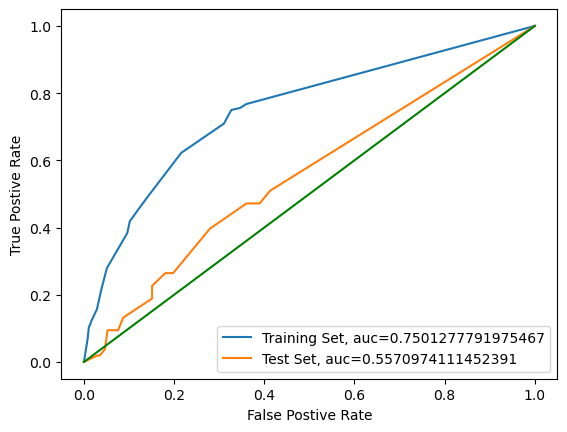

_____________________________________________________________________________________________________
Algorithm: svm
Label: label
SVC(C=3, probability=True)
[[0.74721387 0.25278613]
 [0.31975961 0.68024039]
 [0.58081861 0.41918139]
 [0.58773389 0.41226611]
 [0.24298273 0.75701727]
 [0.24751932 0.75248068]
 [0.72675181 0.27324819]
 [0.88264013 0.11735987]
 [0.62129553 0.37870447]
 [0.47245515 0.52754485]
 [0.67005805 0.32994195]
 [0.78236674 0.21763326]
 [0.1539247  0.8460753 ]
 [0.3643812  0.6356188 ]
 [0.25099881 0.74900119]
 [0.88864794 0.11135206]
 [0.88977495 0.11022505]
 [0.65309382 0.34690618]
 [0.75847545 0.24152455]
 [0.90965835 0.09034165]
 [0.52529091 0.47470909]
 [0.75784614 0.24215386]
 [0.94741564 0.05258436]
 [0.79302107 0.20697893]
 [0.54594267 0.45405733]
 [0.94029277 0.05970723]
 [0.3542612  0.6457388 ]
 [0.86285139 0.13714861]
 [0.62111259 0.37888741]
 [0.20834474 0.79165526]
 [0.38141199 0.61858801]
 [0.31540838 0.68459162]
 [0.26317948 0.73682052]
 [0.79164998 0.208

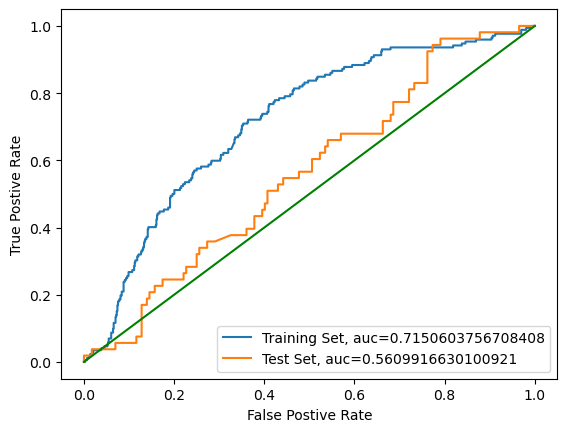

_____________________________________________________________________________________________________
Algorithm: knn
Label: label
KNeighborsClassifier(leaf_size=50)
[[0.6 0.4]
 [0.4 0.6]
 [0.4 0.6]
 [0.8 0.2]
 [0.4 0.6]
 [0.8 0.2]
 [0.6 0.4]
 [1.  0. ]
 [0.  1. ]
 [0.4 0.6]
 [0.4 0.6]
 [1.  0. ]
 [1.  0. ]
 [0.4 0.6]
 [0.6 0.4]
 [1.  0. ]
 [0.2 0.8]
 [0.4 0.6]
 [1.  0. ]
 [1.  0. ]
 [0.6 0.4]
 [0.8 0.2]
 [0.4 0.6]
 [0.8 0.2]
 [0.2 0.8]
 [0.8 0.2]
 [0.6 0.4]
 [1.  0. ]
 [0.6 0.4]
 [0.8 0.2]
 [0.4 0.6]
 [0.4 0.6]
 [0.2 0.8]
 [0.6 0.4]
 [1.  0. ]
 [0.2 0.8]
 [1.  0. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.2 0.8]
 [0.6 0.4]
 [0.2 0.8]
 [0.4 0.6]
 [0.4 0.6]
 [0.4 0.6]
 [0.6 0.4]
 [1.  0. ]
 [0.4 0.6]
 [0.2 0.8]
 [0.2 0.8]
 [0.4 0.6]
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]
 [0.6 0.4]
 [0.4 0.6]
 [0.4 0.6]
 [0.2 0.8]
 [0.8 0.2]
 [0.4 0.6]
 [0.4 0.6]
 [0.6 0.4]
 [1.  0. ]
 [0.4 0.6]
 [0.4 0.6]
 [0.6 0.4]
 [0.6 0.4]
 [0.2 0.8]
 [1.  0. ]
 [0.6 0.4]
 [1.  0. ]
 [0.6 0.4]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]

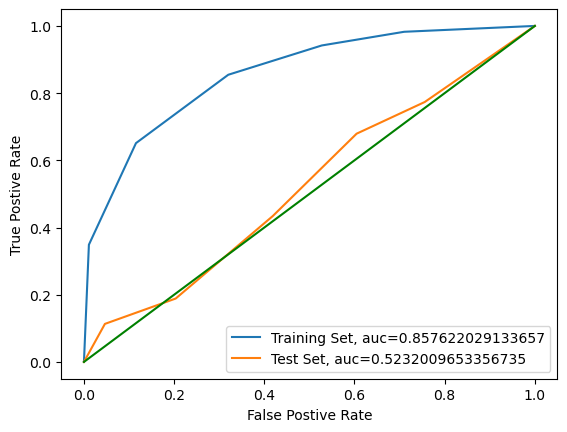

In [40]:
cross_validation(input_df_train, output_df_train, input_df_test, output_df_test, options, algorithms, _scoring)

In [41]:
#model = joblib.load('sgd_elastic_class_model.joblib')